# ODE tutorial


In [1]:
from typing import Any, Callable, Iterable, Sequence, Union, cast

import matplotlib.pyplot as plt
import numpy as np
import pkg_resources
from modelbase.ode import Model, Simulator
from numpy.typing import NDArray
from scipy.integrate import solve_ivp

Vector = Union[Sequence[float], NDArray[np.float64]]
Float = Union[float, np.float64]

for pkg in ("modelbase", "assimulo"):
    print(f"{pkg} version: {pkg_resources.get_distribution(pkg).version}")


def time_points(start: float, end: float, points: int) -> dict[str, tuple[float, float] | NDArray]:
    t_eval = np.linspace(start, end, points)
    t_span: tuple[float, float] = (t_eval[0], t_eval[-1])
    return dict(t_span=t_span, t_eval=t_eval)

modelbase version: 1.13.0
assimulo version: 3.2.9


## Numerical integration

**Euler's method** is a numerical  approximation of the solution of a first-order initial value problem of the form $\frac{dy}{dt} = f(t, y)$ with the inital condition $y(t_0) = y_0$.

The strategy of Euler’s method is as follows: using a **tangent line approximation** of the unknown function, for $y_1$ close to $y_0$ we have
  
$$\begin{align*}    
y(t_1) &\approx \frac{dy(t_0)}{dt} (t_1-t_0) + y(t_0) \\
   &= f(t_0, y_0) (t_1 - t_0) + y_0
\end{align*}$$

This process is then repeated as often as needed, until the desired $t_{end}$ is reached.

If we violate the assumption that $y_1$ close to $y_0$, we see that the tangent is not a good predictor of the next point anymore.

![](assets/euler-tangent-step-size.png)

It is thus important to always set the integration step size accordingly.

### Exercise: Euler method


**Step 1**

Create a function to do a single euler step with the signature `step(t0: float, t1: float, y0: float, f: Callable[[float, float], float]) -> float`

In [2]:
def step(t0: float, t1: float, y0: float, f: Callable[[float, float], float]) -> float:
    ...


assert step(0, 1, 1, lambda t, y: y**2 + t) == 2
assert step(0, 1, 2, lambda t, y: y**2 + t) == 6
assert step(0, 1, 3, lambda t, y: y**2 + t) == 12


**Step 2**

Create a function `euler` that takes an iterable of time points and iteratively calculates the euler approximation for the respective time step 

In [3]:
def euler(
    t: Vector, y0: float, f: Callable[[float, float], float]
) -> list[float]:
    ...


assert euler([1, 2, 3], 1, lambda t, y: y**2 + t) == [1, 3, 14]
assert euler(np.array([1, 2, 3]), 1, lambda t, y: y**2 + t) == [1, 3, 14]


**Step 3**

Using you `euler` function, numerically integrate the function

$$ \frac{dy}{dt} = - \frac{y \cdot t}{2}$$

Which has the analytical solution

$$ f(t, y_0) = y_0 \cdot \mathrm{e}^{-\frac{t^2}{4}}$$

Then create a plot comparing the two solutions.

**Step 4**

- Investigate, how the fit of your numerical approximation varies, depending the selected step size
- Create a 3x2 subplot of step sizes `[1, 1/2, 1/4, 1/8, 1/16, 1/32]` in which you plot both your numerical and your analytical solution 

## More advanced methods

While a smaller step size is more accurate, it also requires more computational power.  
So you need to make a tradeoff between the time your integration can take and how well your function needs to be approximated.  
How close enough a solution needs to be is a decision you need to make and depdends on your system.  
A good enough starting point usually is to require both an absolute and relative tolerance of around $10^{-6}$.  

Another observation is that most functions have regions of varying curvature.  
More advanced methods take this into account and adjust the step size dynamically to the local curvature. 

Instead of implementing these ourself, we will take a look at two packages to compare their behaviour.  

Let's  first take a look at the `solve_ivp` (ivp = initial value problem) method from the popular [scipy](https://scipy.org/) package.  

The required inputs of this functions are 

- the python function `f(t, y)`
- start and end point of the integration
- initial values

Optionally, you can also supply tolerances etc, for more information see the function docstring or [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html?highlight=solve_ivp#scipy.integrate.solve_ivp).

### Exercise: integration using scipy

- Investigate, how the fit of the `solve_ivp` approximation varies, depending the selected tolerance
- Create a 3x2 subplot in which you plot both your numerical and your analytical solution for tolerances between `1e-1` and `1e-6`

**Optional**

You can also use the assimulo package, which provides access to the efficient [sundials](https://computing.llnl.gov/projects/sundials) solver suite.

### Exercise: integration using assimulo

- Investigate, how the fit of the `assimulo` approximation varies, depending the selected tolerance
- Create a 3x2 subplot in which you plot both your numerical and your analytical solution for tolerances between `1e-1` and `1e-6`

- How did the two integrators differ?  
- Did you get the same results for the same tolerances?  

Remember to always check your tools before you are using them.

# ODE model building

## SIR model

- Susceptible (S), Infected (I), Recovered (R)
- Total population (N) = S + I + R

$$\begin{align*}
    \frac{dS}{dt} &= -\beta \frac{S \cdot I}{N}  \\
    \frac{dI}{dt} &= \beta \frac{S \cdot I}{N} - \gamma \cdot I \\
    \frac{dR}{dt} &= \gamma \cdot I \\
\end{align*}$$

Let's start with a literal translation of that description.

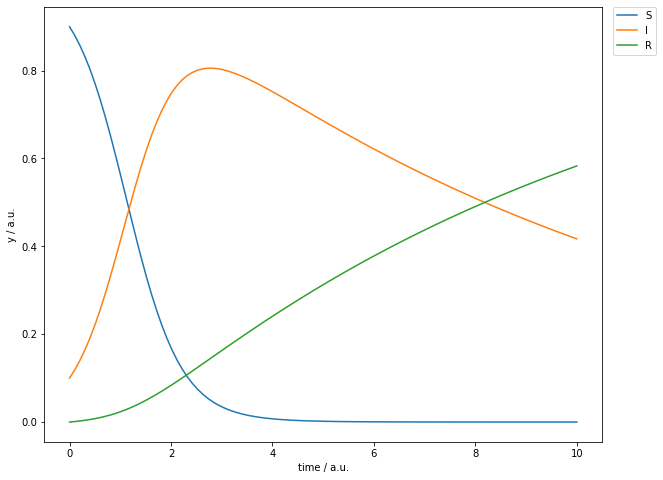

In [10]:
def sir_v1(t: float, y: Iterable[float], beta: float, gamma: float) -> Iterable[float]:
    s, i, r = y
    n = s + i + r

    dsdt = -beta * s * i / n
    didt = beta * s * i / n - gamma * i
    drdt = gamma * i
    return dsdt, didt, drdt


sol = solve_ivp(sir_v1, **time_points(0, 10, 100), y0=[0.9, 0.1, 0], args=(2, 0.1))
t = sol.t
y = sol.y.T

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
ax.set(xlabel="time / a.u.", ylabel="y / a.u.")
ax.legend(["S", "I", "R"], loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()


There is a lot of duplication in the code above (e.g. `beta * s * i / n` appears twice), let's improve on that.

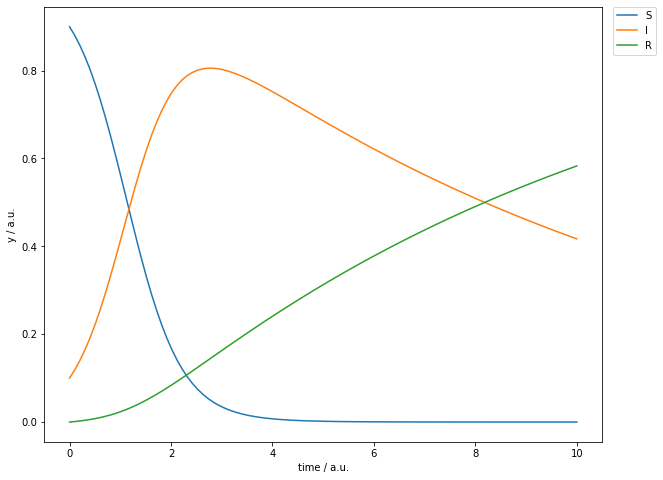

In [11]:
def sir_v2(t: float, y: Iterable[float], beta: float, gamma: float) -> Iterable[float]:
    s, i , r = y
    n = s + i + r

    infection = beta * s * i / n
    recovery = gamma * i

    dsdt = -infection
    didt = infection - recovery
    drdt = recovery
    return dsdt, didt, drdt


t_eval = np.linspace(0, 10, 100)
t_span = (t_eval[0], t_eval[-1])

sol = solve_ivp(sir_v1, t_span=t_span, t_eval=t_eval, y0=[0.9, 0.1, 0], args=(2, 0.1))
t = sol.t
y = sol.y.T

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
ax.set(xlabel="time / a.u.", ylabel="y / a.u.")
ax.legend(["S", "I", "R"], loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()

All cool and stuff, but very it is very easy to introduce subtle errors

- order of unpacked values `s, i , r = y` and initial arguments `y0=[0.9, 0.1, 0]` might not be the same
- order of parameters `beta, gamma` might not be the same as `args=(2, 0.1)`

Inconveniences

- cannot get readouts for the rates of infection and recovery at each time in point directly
- with more parameters, model function will get vary large
- it's hard to programmatically extend / change the model

While this works well for small models, changing the model or creating model-variants requires you to re-write that function, probably introducing errors along the way.  
What you want is to be able to have a *modular* interface to building your models.  

# modelbase introduction

*modelbase* supplies you with the `Model` object, which you can use to iteratively build your models.  
Since *modelbase* is mostly used for work on biochemical networks, the terminology is geared towards that.  
Whenever confusing, I will add a synonym that might be more applicable for the current model.  

Let's begin by creating the model, and adding compounds (variables) and parameters (constants).  

In [12]:
m = Model()
m.add_compounds(["S", "I", "R"])
m.add_parameters(
    {
        "beta": 2,  # new infections caused by one infection
        "gamma": 0.1,  # turnover rate of infected (death or recovery)
    }
)


## Algebraic modules

Next, we will add an **algebraic module** to calculate the total population at each time point.  
Algebraic modules are a way of expressing variables that change over time, but are not returned by the model function.  

For this we first add a normal Python function for doing the calculation.  
Note that when possible these should be general and re-usable whenever possible, to make your model clear to people reading it.  

So the function below could also be called `sum` or `total`.  
You can decide what makes most sense for your target audience - naming is communicating!  


In [13]:
def total_population(S: float, I: float, R: float) -> float:
    return S + I + R


Then we add an algebraic module using `.add_algebraic_module_from_args`.

The following arguments are important for now:

- `module_name`: name of the module. Has to be **unique**
- `function`: The Python function you defined above
- `derived_compounds`: list of derived compounds
- `args`: A list of all arguments that will be passed to the Python function. The order is the order in which the function will receive the arguments!


In [14]:
m.add_algebraic_module_from_args(
    module_name="N",
    function=total_population,
    derived_compounds=["N"],
    args=["S", "I", "R"],
)


## Reactions

To add **reactions** (transitions), just like with algebraic modules we first define the Python functions.  
Like with algebraic modules you should aim at using function names that you can re-use.  
However, in this example it is more clear to just name them directly - there are exceptions to all rules :)


In [15]:
def infection(S: float, I: float, N: float, beta: float) -> float:
    return beta * S * I / N


def turnover(I: float, gamma: float) -> float:
    return gamma * I


Now we will add the reactions to modelbase using the method `.add_reaction_from_args`.

The following arguments are important for now:

- `rate_name`: The name you want to give your rate. Has to be **unique** 
- `function`: The Python function you defined above
- `stoichiometry`: A dictionary defining by how much compounds will be *consumed* (negative value) or *produced* (positive value) by the reaction
- `args`: A list of all arguments that will be passed to the python function. The order is the order in which the function will receive the arguments!

In [16]:
m.add_reaction_from_args(
    rate_name="infection",
    function=infection,
    stoichiometry={"S": -1, "I": 1},
    args=["S", "I", "N", "beta"],
)
m.add_reaction_from_args(
    rate_name="turnover",
    function=turnover,
    stoichiometry={"I": -1, "R": 1},
    args=["I", "gamma"],
)


## Simulating

Now we are already ready to simulate the model!  
To do that, create a `Simulator` object by passing the model into it and then initialise the simulator with a dictionary containing the **initial conditions** of the model.
Then you can simulate the model until time point `t_end = 10` and plot the result.  

There are a lot more plotting functions, especially for larger models.  
Since they are all named `plot_*`, the easiest way you can explore them is to write `s.plot_` and then use the `<TAB>` key for autocompletion.  

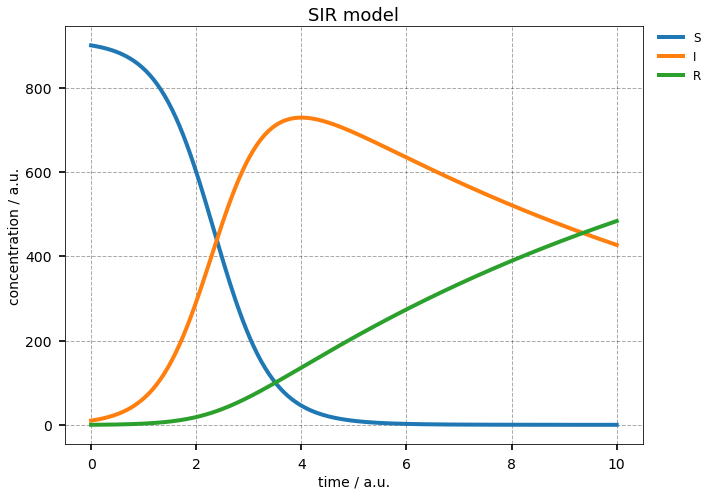

In [17]:
s = Simulator(m)
s.initialise({"S": 900, "I": 10, "R": 0})
s.simulate(10)
fig, ax = s.plot(title="SIR model", xlabel="time / a.u.", ylabel="concentration / a.u.")


Note that we used the derived compound `N` for the total population in our reactions, but we don't see it in the plot.  
This is because derived compounds are not returned to the integrator, and thus not part of the results.  
However, modelbase offers an easy function to plot derived compounds as well, using `plot_all`.  

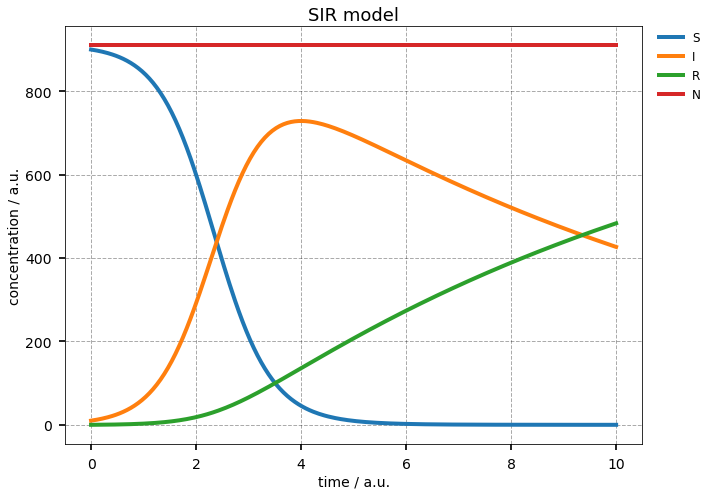

In [18]:
fig, ax = s.plot_all(title="SIR model", xlabel="time / a.u.", ylabel="concentration / a.u.")

You can **continue** a simulation by running `.simulate` again with a *larger* end time point.  
This will not re-run previous time steps.  

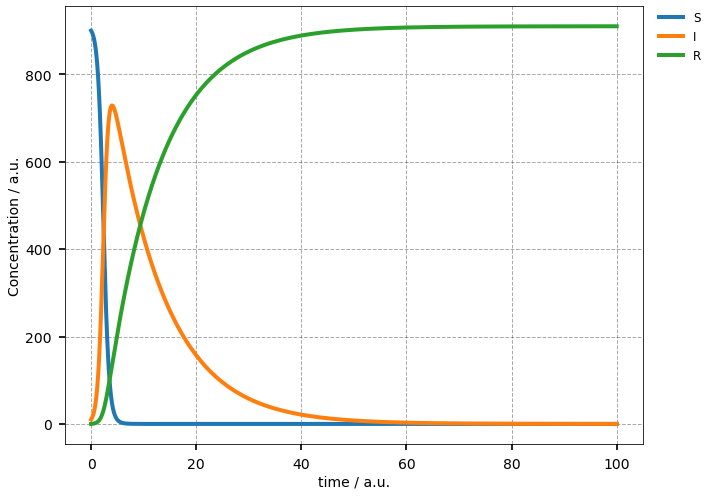

In [19]:
s.simulate(100)
fig, ax = s.plot(xlabel="time / a.u.", ylabel="Concentration / a.u.")
plt.show()

You can calculate the steady state, where $Nv = 0$ using `.simulate_to_steady_state`

In [20]:
_, y_ss = s.simulate_to_steady_state()
print(y_ss)


[[1.85560384e-06 2.99425671e-11 9.09999998e+02]]


Very often you want to systematically investigate the **steady-state concentrations** depending on different values of a parameter.  
For this you can use the `Simulator.parameter_scan` method.

In [21]:
y_scan = s.parameter_scan(parameter_name="k_in", parameter_values=np.linspace(0, 10, 11))
print(y_scan)


k_in:   0%|          | 0/11 [00:00<?, ?it/s]

             S             I           R      N
0.0   0.000002  2.994257e-11  909.999998  910.0
1.0   0.000002  2.994257e-11  909.999998  910.0
2.0   0.000002  2.994257e-11  909.999998  910.0
3.0   0.000002  2.994257e-11  909.999998  910.0
4.0   0.000002  2.994257e-11  909.999998  910.0
5.0   0.000002  2.994257e-11  909.999998  910.0
6.0   0.000002  2.994257e-11  909.999998  910.0
7.0   0.000002  2.994257e-11  909.999998  910.0
8.0   0.000002  2.994257e-11  909.999998  910.0
9.0   0.000002  2.994257e-11  909.999998  910.0
10.0  0.000002  2.994257e-11  909.999998  910.0


If you are also interested in the **steady-state fluxes**, you can use the `Simulator.parameter_scan_with_fluxes` method.

In [22]:
y_scan, v_scan = s.parameter_scan_with_fluxes(parameter_name="k_in", parameter_values=np.linspace(0, 10, 11))
print(v_scan)

k_in:   0%|          | 0/11 [00:00<?, ?it/s]

         infection      turnover
0.0   1.221133e-19  2.994257e-12
1.0   1.221133e-19  2.994257e-12
2.0   1.221133e-19  2.994257e-12
3.0   1.221133e-19  2.994257e-12
4.0   1.221133e-19  2.994257e-12
5.0   1.221133e-19  2.994257e-12
6.0   1.221133e-19  2.994257e-12
7.0   1.221133e-19  2.994257e-12
8.0   1.221133e-19  2.994257e-12
9.0   1.221133e-19  2.994257e-12
10.0  1.221133e-19  2.994257e-12


## Introspection & bug fixing

Not all the times model creation goes as smoothly as in the example.  
To allow you to quickly find an error, modelbase contains introspection methods, to quickly find out where things went wrong.  
We can check the constructed system, by taking a look at the stoichiometric matrix, the fluxes and the right hand side.

Let's start with the stoichiometric matrix, which modelbase returns as a `dataframe`.  
Here you can see which reaction affects which compound by how much.  
If a number here is unexpected, you know that you need to change the respective `stoichiometry` dictionary.  

In [23]:
m.get_stoichiometric_df()

,infection,turnover
I,1.0,-1.0
R,0.0,1.0
S,-1.0,0.0


The next step is to check the fluxes of the system.  
This is especially useful to see whether the direction of all reactions is as expected or to check if a reaction is overly large or small

In [24]:
m.get_fluxes_df({"S": 0.9, "I": 0.1, "R": 0})

,infection,turnover
0.0,0.18,0.01


You *can* also check the right hand side of the differential equation.  
Since that is just the stoichiometric matrix multiplied by the fluxes this doesn't give any new information, but it is an easy way to check if all reactions are going in the correct direction.  

In [25]:
m.get_right_hand_side({"S": 0.9, "I": 0.1, "R": 0})

{'dSdt': -0.18000000000000002, 'dIdt': 0.17, 'dRdt': 0.010000000000000002}

Some bugs only appear after a certain amount of time.  
The simulator object allows checking the concentrations over time (results) and fluxes over time.  

If you need to access the concentrations over time for something other than plotting, you can do that using `.get_results_df()`

In [26]:
s.get_results_df().head(5)  # type: ignore

,S,I,R
0.000000e+00,900.000000,10.000000,0.000000e+00
3.432259e-10,900.000000,10.000000,3.432259e-10
3.432602e-06,899.999932,10.000064,3.432624e-06
3.775519e-05,899.999253,10.000709,3.775691e-05
9.249803e-05,899.998170,10.001737,9.250675e-05


A just like with the model you can get the fluxes.

In [27]:
s.get_fluxes_df().head(5)  # type: ignore


,infection,turnover
0.000000e+00,19.780220,1.000000
3.432259e-10,19.780220,1.000000
3.432602e-06,19.780346,1.000006
3.775519e-05,19.781606,1.000071
9.249803e-05,19.783616,1.000174


## Model interaction

Creating a model is fun, but interactively working with it is even better.  
You can at any point add, remove or update any part of the model.  
If you want to re-use the same simulator, run `.clear_results()` to reset the simulator, or `.initialise` if the number of compounds has changed.  
In most cases however, we advise to simply create a new `Simulator` object.  


### Example: extending model with population dynamics

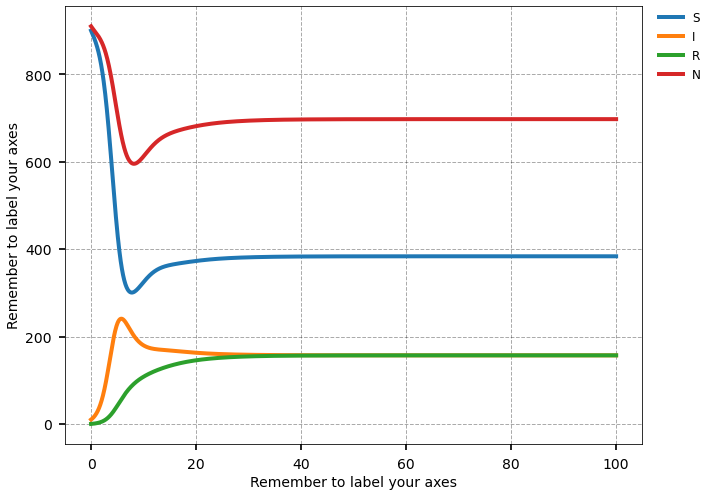

In [28]:
def proportional(x: float, y: float) -> float:
    return x * y

def births(n: float, max_birth_rate: float, capacity: float) -> float:
    return max_birth_rate * (capacity - n) / capacity * n


m.add_parameters(
    {
        "capacity": 1000,
        "max_birth_rate": 1,
        "death_rate_normal": 0.1,
        "death_rate_infected": 1,
    }
)

m.add_reaction_from_args(
    rate_name="births_from_s",
    function=births,
    stoichiometry={"S": 1},
    args=["N", "max_birth_rate", "capacity"],
)
m.add_reaction_from_args(
    rate_name="death_s",
    function=proportional,
    stoichiometry={"S": -1},
    args=["S", "death_rate_normal"],
)
m.add_reaction_from_args(
    rate_name="death_i",
    function=proportional,
    stoichiometry={"I": -1},
    args=["I", "death_rate_infected"],
)
m.add_reaction_from_args(
    rate_name="death_r",
    function=proportional,
    stoichiometry={"R": -1},
    args=["R", "death_rate_normal"],
)

s = Simulator(m)
s.initialise({"S": 900, "I": 10, "R": 0})
s.simulate(100)
s.update_parameter("beta", 2)
fig, ax = s.plot_all()


## Derived parameters

Quite often we have parameters that depend on other parameters.  
That means they don't change during the simulation, but they can change during runs if you change another parameter.  
You can add such a derived parameter using `add_derived_parameter`, which takes the following arguments

- `parameter_name`: name of the derived parameter
- `function`: Python function
- `parameters`: Iterable of inputs for the Python function.

`modelbase` will then do the housekeeping for you to automatically update the derived parameter if you change one of the parameters it depends on.  

```python
m = Model()
m.add_parameter("R", 8.314)                               # gas constant
m.add_parameter("T", 298)                                 # 25 °C
m.add_derived_parameter("RT", proportional, ["R", "T"])
print(m.parameters)                                       # {'R': 8.314, 'T': 298, 'RT': 2477.572}

# Note how RT updates as well
m.update_parameter("T", 303)                              # 303 °C
print(m.parameters)                                       # {'R': 8.314, 'T': 303, 'RT': 2519.142}
```

### Exercise: FILL ME

## Reducing state

When you are exploring your model there is a high chance that you will change something and forget about it.  
Programming in such a *stateful* way is prone to errors, which is why there are two things you can do to minimise the amount of state.  
First, you can use a *context manager* to only apply changes to a model in an indented block.

```python
m = Model()
print(m.parameters)             # {}

with m as temp:
    temp.add_parameter("x", 1)  
    print(temp.parameters)      # {'x': 1}

print(m.parameters)             # {}
```

Secondly, you can modularise building your models by putting them into isolated functions.  
Note that below `create_model_v2` calls `create_model_v1`, instead of repeating all the steps in `create_model_v1`.  
This makes it very clear which parts of your model are actually changing and avoids errors where you only applied a change in *one* of potentially many models.    

```python
def create_model_v1() -> Model:
    m = Model()
    m.add_compounds(["S", "P"])
    m.add_parameters({"k_in": 1, "k_1": 1, "k_out": 1})
    m.add_reaction_from_args("v0", constant, {"S": 1}, ["k_in"])
    m.add_reaction_from_args("v1", proportional, {"S": -1, "P": 1}, ["k_1", "S"])
    m.add_reaction_from_args("v2", proportional, {"P": -1}, ["k_out", "P"])
    return m


def create_model_v2() -> Model:
    m = create_model_v1()
    m.add_parameter("k_1_rev", 0.5)
    m.add_reaction_from_args("v1_rev", proportional, {"P": -1, "S": 1}, ["k_1_rev", "P"])
    return m
```

### Exercise: FILL ME

# Bonus: Label models

<!-- ![label model](assets/tpi.png) -->
<img src="assets/tpi.png" style="max-width: 400px">

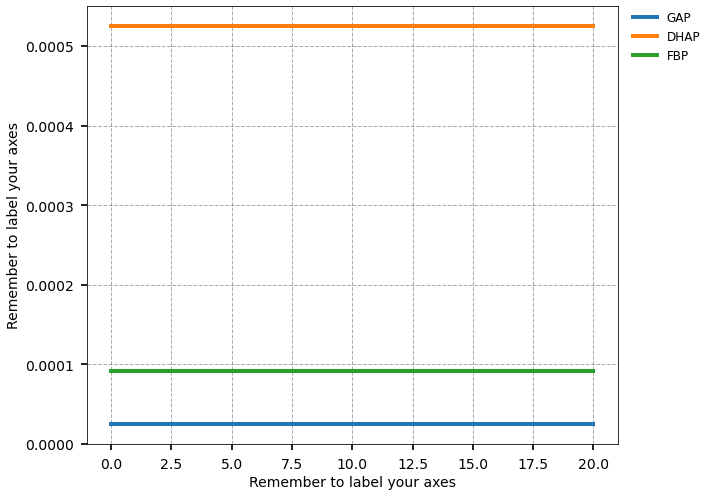

In [29]:
p = {
    "kf_TPI": 1.0,
    "Keq_TPI": 21.0,
    "kf_Ald": 2000.0,
    "Keq_Ald": 7000.0,
}

GAP0 = 2.5e-5
DHAP0 = GAP0 * p["Keq_TPI"]
FBP0 = GAP0 * DHAP0 * p["Keq_Ald"]

base_y0 = {"GAP": GAP0, "DHAP": DHAP0, "FBP": FBP0}

p["kr_TPI"] = p["kf_TPI"] / p["Keq_TPI"]
p["kr_Ald"] = p["kf_Ald"] / p["Keq_Ald"]


def mass_action_1(kf, s):
    return kf * s


def mass_action_2(kf, s1, s2):
    return kf * s1 * s2


m = Model()
m.add_compounds(["GAP", "DHAP", "FBP"])
m.add_parameters(p)
m.add_reaction_from_args("TPIf", mass_action_1, {"GAP": -1, "DHAP": 1}, ["kf_TPI", "GAP"])
m.add_reaction_from_args("TPIr", mass_action_1, {"DHAP": -1, "GAP": 1}, ["kr_TPI", "DHAP"])
m.add_reaction_from_args("ALDf", mass_action_2, {"DHAP": -1, "GAP": -1, "FBP": 1}, ["kf_Ald", "DHAP", "GAP"])
m.add_reaction_from_args(
    "ALDr",
    mass_action_1,
    {
        "FBP": -1,
        "DHAP": 1,
        "GAP": 1,
    },
    ["kr_Ald", "FBP"],
)

# Simulate
s = Simulator(m)
s.initialise(base_y0)
t, y = s.simulate(20)
s.plot()
plt.show()

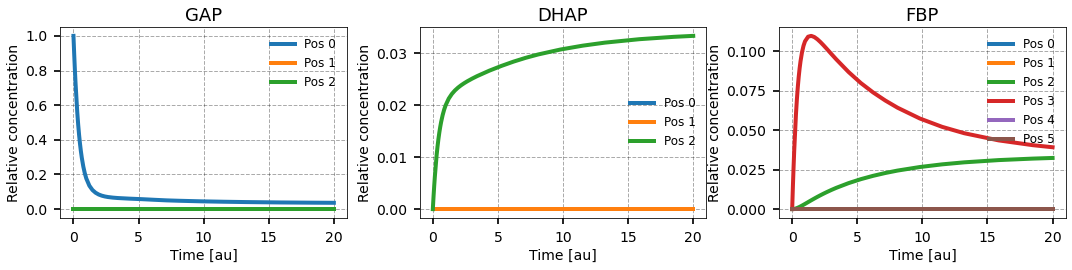

In [30]:
lm = m.to_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)


# Simulate
y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
ls = Simulator(lm)
ls.initialise(y0)
t, y = ls.simulate(20)
fig, ax = ls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"],
    ncols=3,
    sharey=False,
    relative=True,
    xlabels="Time [au]",
)
plt.show()